# What is Time Series

Time series is a **sequence** of data in successive order of time. The value of data when combined with time ofen become more useful. We can gain more information by doing timeseries analysis, wich often resulting in forecasting. Let's take a look in a most common time series data, stock data.

A few days ago (January 25th, 2020 to be exact), I read an article saying that Tesla has overcome Volkswagen becoming the second most valuable auto company before General Motor, and Volkswagen praised Tesla and start its path to renewable energy (electric car). This is a great news since i'm a fan of Tesla. So now, let's try to take their stock price from yahoo.  

source: [bbc](https://www.bbc.com/news/business-51214824), [wall street journal](https://www.wsj.com/articles/tesla-tops-volkswagen-to-become-second-most-valuable-auto-maker-11579709320)

In [1]:
from pandas_datareader import data
import pandas as pd

In [2]:
symbol = ['VOW3.DE', 'TSLA']
# symbol = ['AAPL', 'TL0.DE']
source = 'yahoo'
start_date = '2012-01-01'
end_date = '2020-01-20'
stock = data.DataReader(symbol, source, start_date, end_date)

In [3]:
vw = stock.xs('VOW3.DE', level='Symbols', axis=1)
tesla = stock.xs('TSLA', level='Symbols', axis=1)

In [4]:
# apple = apple.resample('D').mean().fillna(method='ffill').fillna(method='bfill')

In [5]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm

from pylab import rcParams

In [6]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.plot(x, y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

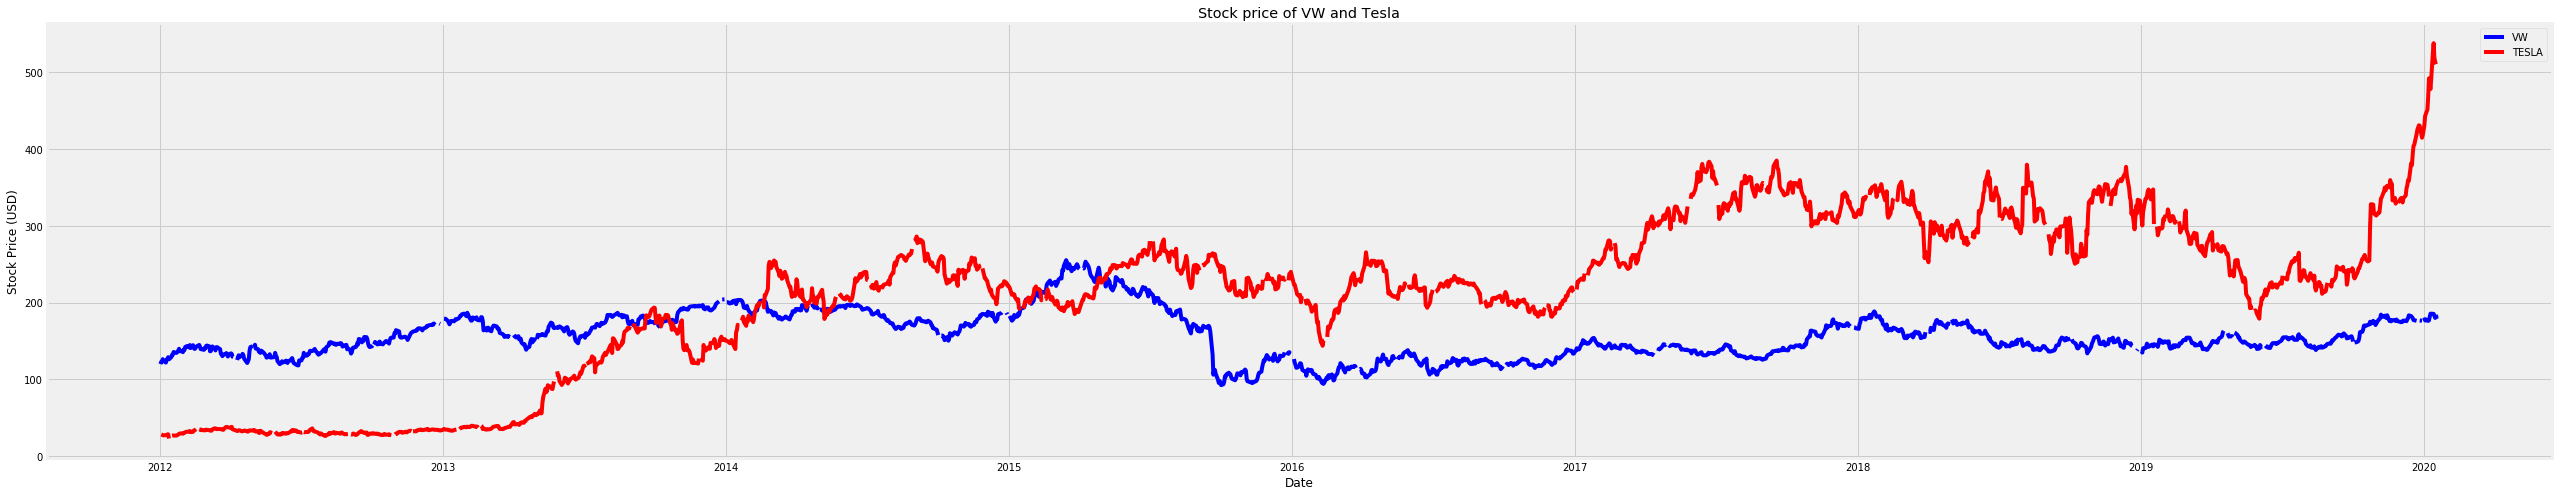

In [7]:
# plot_df(apple, apple.index, apple['Close'])
rcParams['figure.figsize'] = 40, 8
plt.plot(vw.index, vw['Close'], 'b-', label = 'VW')
plt.plot(tesla.index, tesla['Close'], 'r-', label = 'TESLA')
plt.xlabel('Date'); plt.ylabel('Stock Price (USD)')
plt.title('Stock price of VW and Tesla')
plt.legend();

If you see the intersect, actually Tesla has overcome Volkswagen in the end of 2015, so why is it reported now ? well.. the graph above is a stock price chart. **It doesn't represent** the value of a company. The real value of a company (Market Cap) = Stock Price * Shares. It is true that Tesla's stock price has overcome VW years ago. But Tesla's shares is not many as VW's then, making it less valueable. 

# Missing Values in Time-Series Object

Before we continue, we need to cleanup the data first. As you can see, there are holes in some dates. This could be happened due to market error, or something we haven't inspect yet. We need to fix it otherwise the forecasting model can't work properly. 

In [8]:
print(f"""Tesla Missing Values: {tesla.isna().any(axis=1).sum()}\n{tesla[tesla.isna().any(axis=1)].index} \n
Volkswagen Missing Values: {vw.isna().any(axis=1).sum()}\n{vw[vw.isna().any(axis=1)].index}""")


Tesla Missing Values: 54
DatetimeIndex(['2012-01-02', '2012-01-16', '2012-02-20', '2012-05-28',
               '2012-07-04', '2012-09-03', '2012-10-29', '2012-10-30',
               '2012-11-22', '2013-01-21', '2013-02-18', '2013-05-27',
               '2013-07-04', '2013-09-02', '2013-11-28', '2014-01-20',
               '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01',
               '2014-11-27', '2015-01-19', '2015-02-16', '2015-07-03',
               '2015-09-07', '2015-11-26', '2015-12-25', '2016-01-18',
               '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-11-24', '2017-01-02', '2017-01-16', '2017-02-20',
               '2017-05-29', '2017-07-04', '2017-09-04', '2017-11-23',
               '2018-01-15', '2018-02-19', '2018-05-28', '2018-07-04',
               '2018-09-03', '2018-11-22', '2018-12-05', '2019-01-21',
               '2019-02-18', '2019-05-27', '2019-07-04', '2019-09-02',
               '2019-11-28', '2020-01-20'],
        

There are many ways to fill these `nan`s. If you have a good forecasting model, you may predict each missing values. But it's not what we're gonna do since we haven't modelled it yet. SO let's start with the most simple method, doing a `ffill` or `bfill` to just copy the previous/afterward data value. 

In [9]:
def fill_missing(df):
    return df.fillna(method='ffill').fillna(method='bfill')

In [10]:
tesla, vw = fill_missing(tesla), fill_missing(vw)

In [11]:
print(f"""Tesla Missing Values: {tesla.isna().any(axis=1).sum()}
Volkswagen Missing Values: {vw.isna().any(axis=1).sum()}""")

Tesla Missing Values: 0
Volkswagen Missing Values: 0


Now we're good to go. For the rest of this notebook, we will only use Tesla data to reduce the redundance. 

# Time series Components

There are three components of time-series data: 
- Trend: the movement of the data on a larger scale (moving average)
- Seasonality: repeated seasonal fluctuations
- Residual: any fluctuations not captured from trend or seasonality (should be random)

A time series can be modeled as **additive** or **multiplicative** time series depending on its nature of trend and seasonality. \
**Aditive Time Series** \
observed = Trend + Seasonal + Residual \
**Multiplicative Time Series** \
observed = Trend $\times$ Seasonal $\times$ Residual

*Source: Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on January 22, 2020.*

So, how we diffrentiate additive and multiplicative time series, please take a look an example image below ([source](https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/))
![](res/add_vs_multi.png)

Based on data values, if the magnitude of seasonality changes overtime (see image on the right), then the data is multiplicative. Our data however doesn't show clear evidence of growing/shrinking magnitude of seasonality, so we assume it's an additive time series. Please take a look at it once again. 

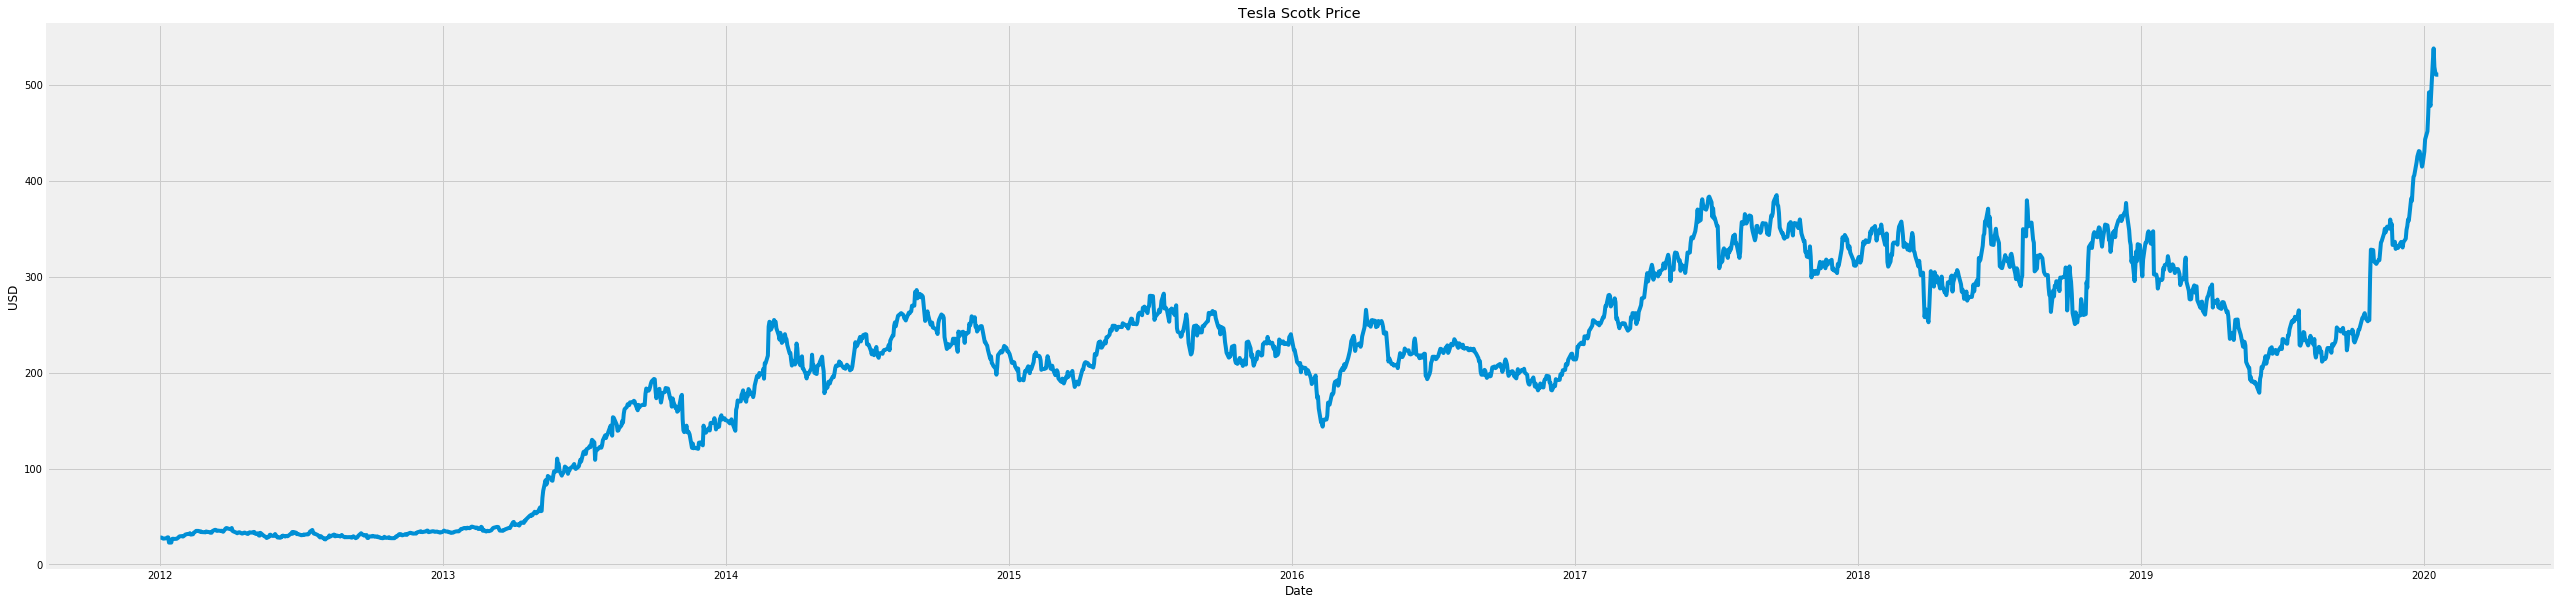

In [12]:
rcParams['figure.figsize'] = 40, 10
plot_df(tesla, tesla.index , tesla['Close'], title='Tesla Scotk Price',ylabel='USD')

Now let's try to extract the subcomponents. 

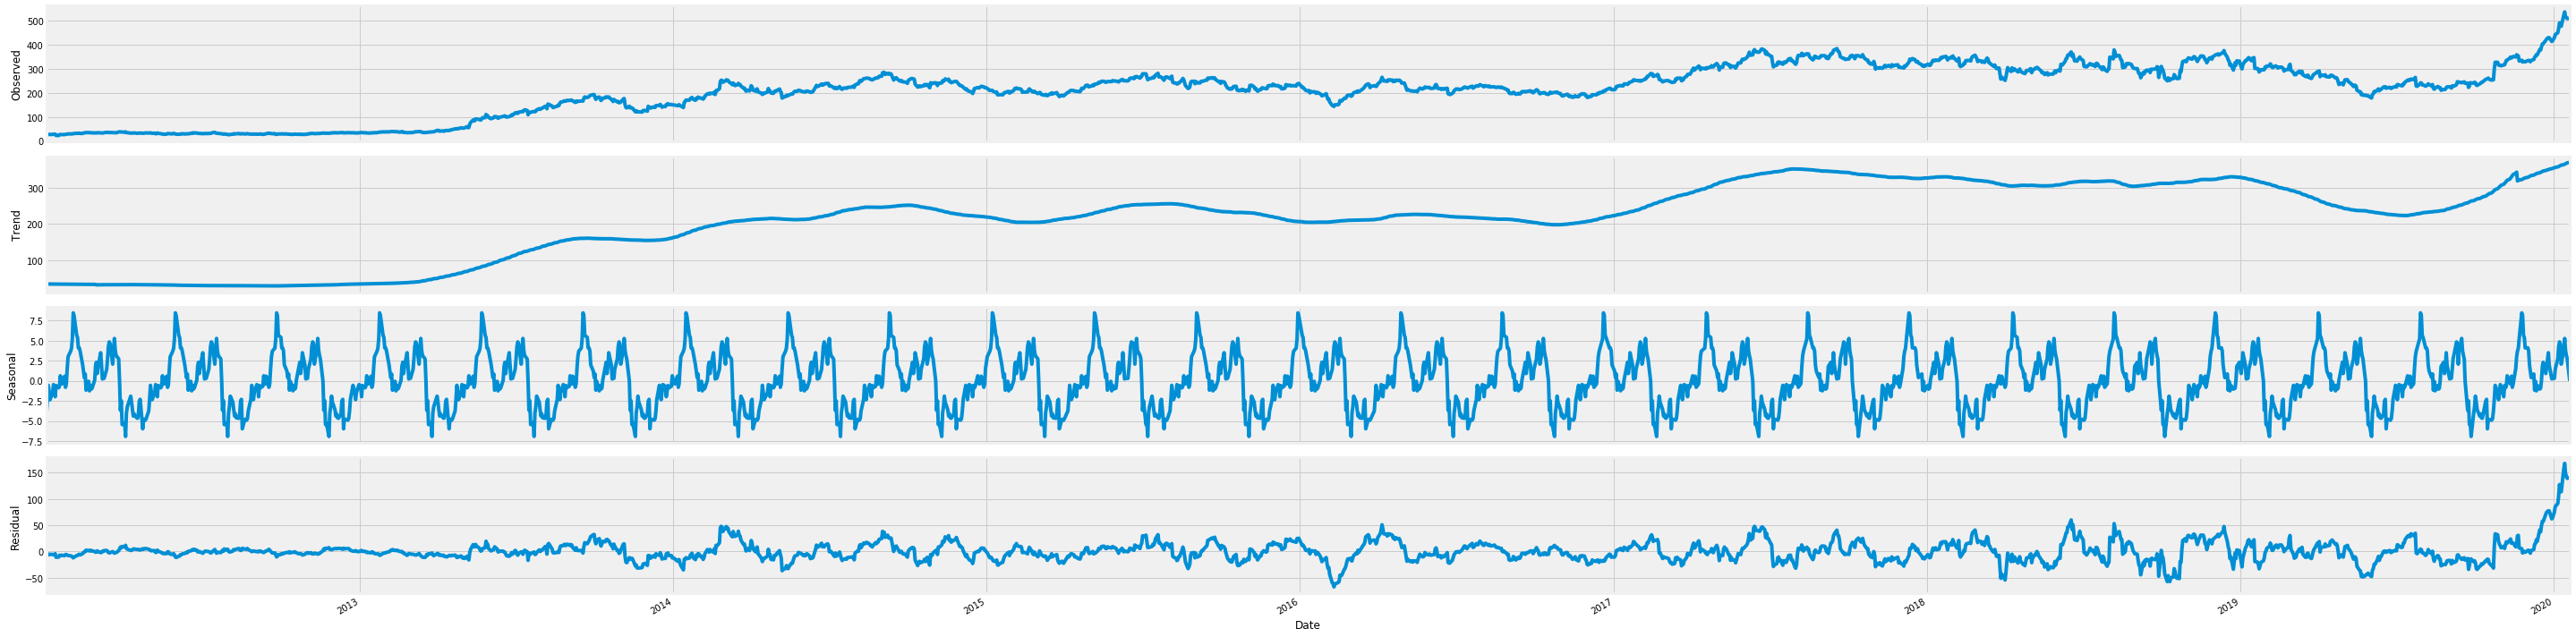

In [13]:
decomposition = sm.tsa.seasonal_decompose(tesla['Close'], model='additive', freq=7*4*3,extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

On the example above, we are using `freq= 7*4*3` (~3 months) to model our data. You can tune it by holding into `trend` visualizations. If the trends visualizations is smooth, and the seasonal has patterns, then it's good to continue. 

The `extrapolate_trend='freq'` will make the length of residual, trend, and seasonal the same by taking care of any missing values at the beginning of the series. 

Now that we already decompose the data, let's try to reconstruct and see whether the formula are correct or not. 

In [14]:
tesla_rc = pd.concat([decomposition.seasonal, decomposition.resid, decomposition.trend, decomposition.observed], axis=1)
tesla_rc.columns = ['seasonal', 'residual', 'trend', 'observation']
tesla_rc['total'] = tesla_rc['seasonal'] + tesla_rc['residual'] + tesla_rc['trend']
tesla_rc.head()

,seasonal,residual,trend,observation,total
Date,,,,,
2012-01-02,-3.738150,-2.712656,34.530806,28.080000,28.080000
2012-01-03,-2.291262,-4.131422,34.502684,28.080000,28.080000
2012-01-04,-0.558103,-6.206460,34.474562,27.709999,27.709999
2012-01-05,-1.368688,-5.957750,34.446440,27.120001,27.120001
2012-01-06,-2.347916,-5.160402,34.418318,26.910000,26.910000


In [15]:
(tesla_rc['total'] == tesla_rc['observation']).mean()

1.0

Since the mean of all boolean value is 1, we have a proof that the formula is true. 

# Stationary Time Series

Stationary time-series is time series data that the values don't follow a function of time. 

The difference between stationary time-series and non stationary can be obvious in these example ([source](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322))
![](res/stationary.png)



By the example above, we can conclude that variance in stationary time-series will likely to be constant for each window. Why we need stationary time-series? it's because stationary time-series is easier to be analyzed and most of forecasting algorithm works well with stationary time-series. Let's look once again into our data

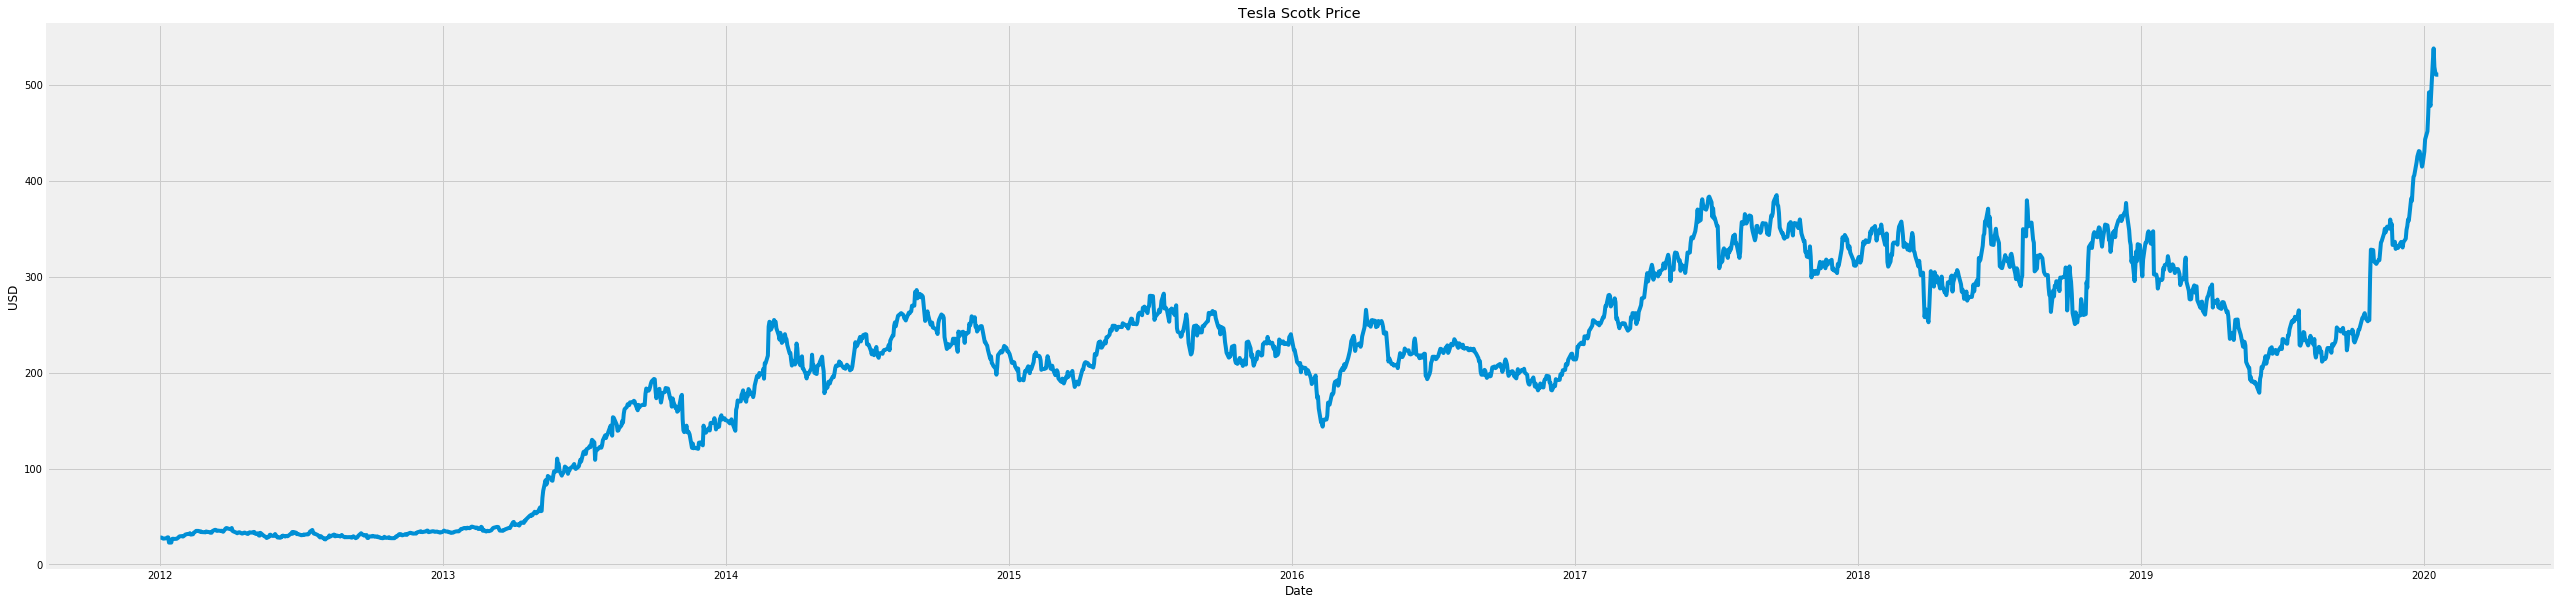

In [16]:
plot_df(tesla, tesla.index , tesla['Close'], title='Tesla Scotk Price',ylabel='USD')

By looking into our data, it seems that the data is not stationary. If you're a bit skeptical about it, there exists several measurement to test data stationarity: 
- Augmented Dicky Fuller (ADF) test
- Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)

Let's try to check the stationarity of our data using ADF, the most common way to test stationarity. 

In [18]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(tesla['Close'])
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")


ADF Value : -0.7349303346862384
P Value : 0.837493178725177



When you run the ADF test, the result should be negative value, and the P-value should beneath certain threshold. For example, we will use p-value < 5%. Based on the result, the ADF Value is -0.7 wich means our data is not stationary enough. This result also show that p-value >5%, even far more than 10%. This indicate that our data is statistically not stationary. 

## Change into stationary time-series

There are some ways to make a series into stationary: 
- Differencing the Series
- Transform the series to its log 
- Transform the series to its root 
- Other combination

First, let's try the easiest one, using log. Applying log to the data will effectively remove the magnitude of changes and also can make the time-series from multiplicative into additive. Now let's see how stationary it is

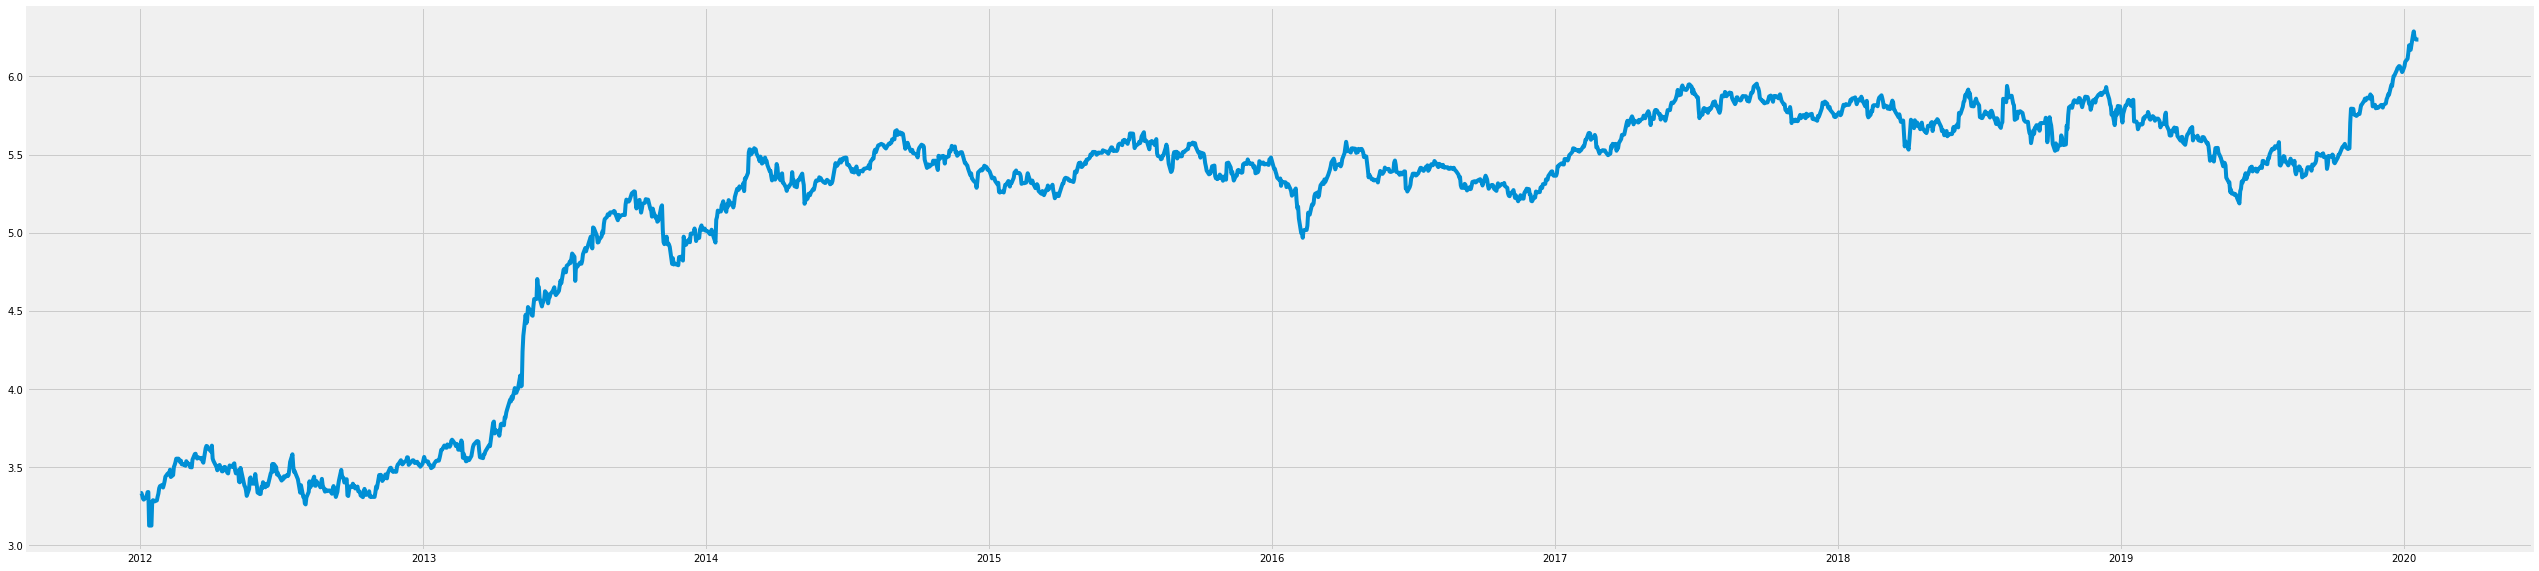

In [25]:
plt.plot(tesla.apply(np.log)['Close'])

In [26]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(np.log(tesla['Close']))
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")


ADF Value : -1.845695912607128
P Value : 0.35802234148912654



Looks like transforming our data to its log is not enough to make it stationary. Let's  try tochange the method, differencing. Differencing the data is mathematically applying the function of $$data_t = data_t - data_{t-1}$$ for `t` moving from the length of data to 2.

You have to be aware by the fact that doing differencing will make the first data to be `NAN` since there is no data beforehand. This means, doing differencing once will remove the first data, and we have to deal with it (use fillna or dropna). Doing differencing twice will remove two first data, and so on. Now let's see wheter doing differencing once will make the data into stationary time series or not

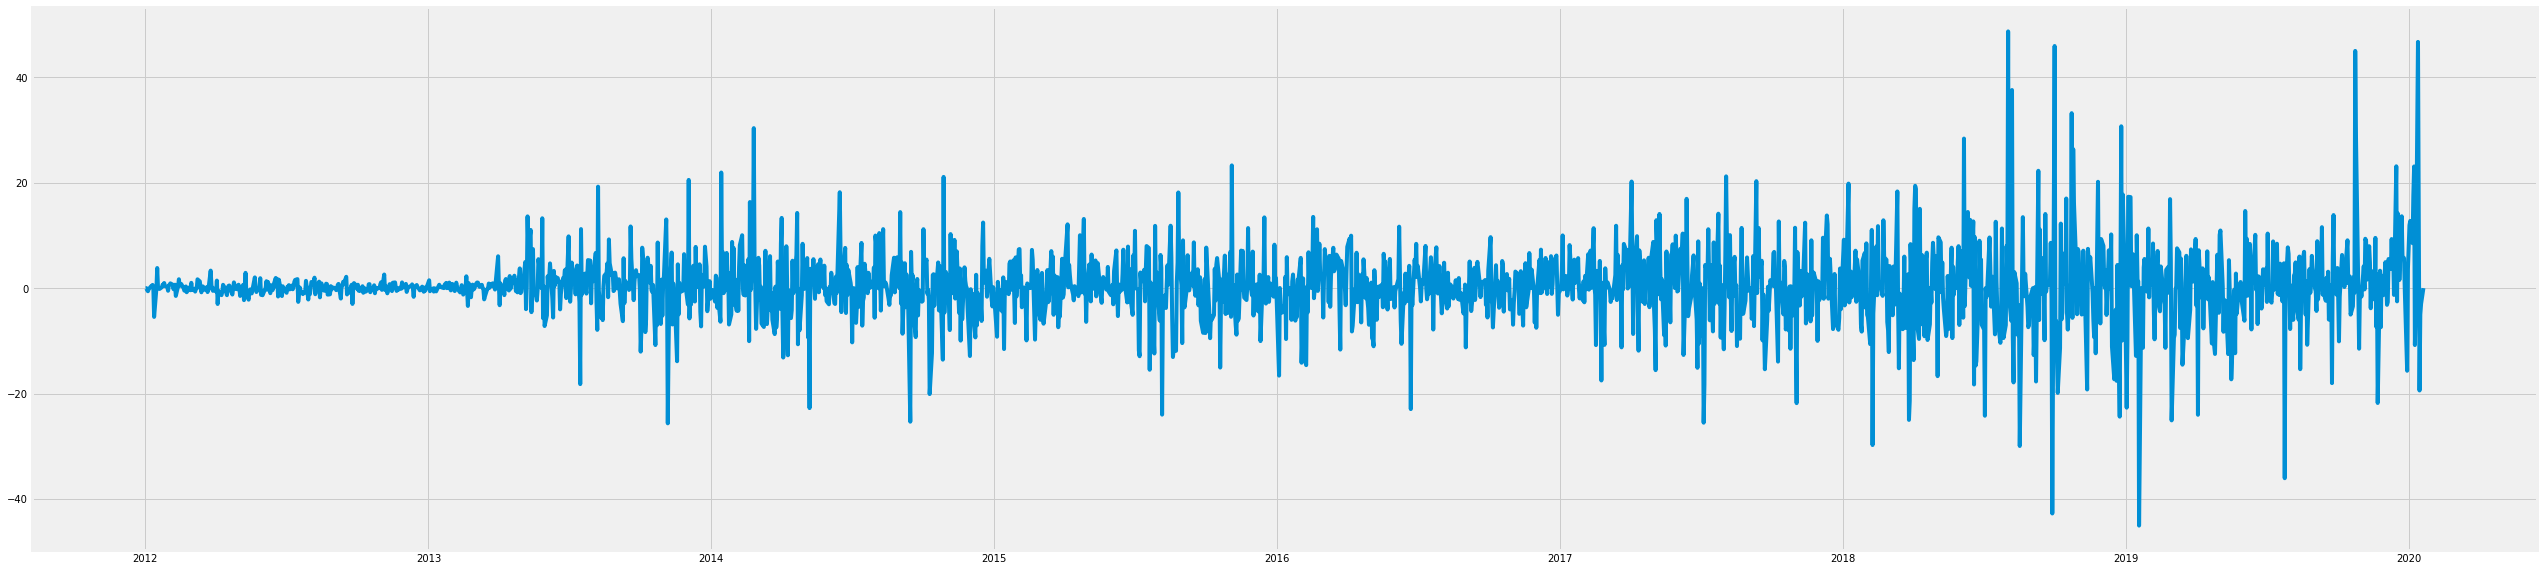

In [27]:
plt.plot(tesla['Close'].diff(1).fillna(0))

In [28]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(np.log(tesla['Close']).diff(1).fillna(0))
adf_test = adfuller((tesla['Close']).diff(1).fillna(0))
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")


ADF Value : -10.234289901709772
P Value : 4.935557326616183e-18



In [29]:
tesla_st = tesla.diff(1).fillna(0)
tesla_st.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2012-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2012-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2012-01-04,-0.370001,-0.370001,-0.830000,-0.150000,-0.730001,-298000.0
2012-01-05,-0.589998,-0.589998,-0.740000,-0.650000,-0.449999,375400.0
2012-01-06,-0.210001,-0.210001,-0.139999,-0.440001,-0.559999,-19200.0


But, doing transformation means we changed the data. Yes, **we changed the data**. But don't worry, we can still try to reconstruct it into original form. However, it depends on how you changed the data. Since we are using diff wich resuling in the differences between current data and previous one, a cumulative sum (`cumsum`) will work as a cure. 

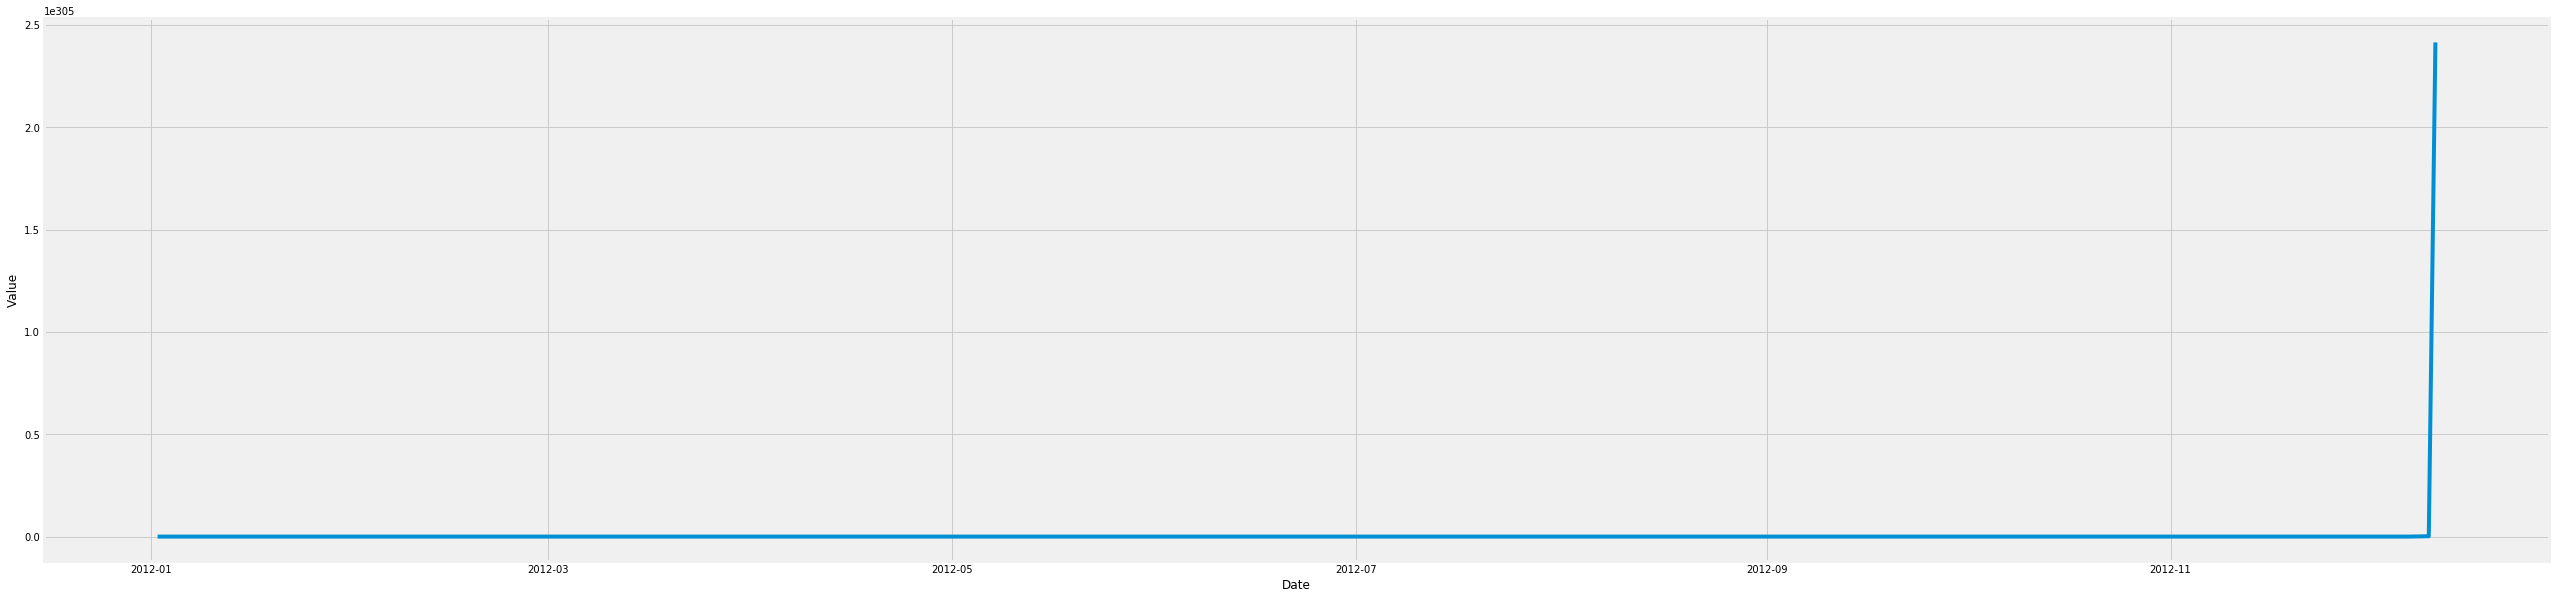

In [30]:
tesla_reconstruct = tesla_st.copy()
# tesla_reconstruct = tesla_reconstruct.cumsum().apply(np.exp)
tesla_reconstruct = tesla_reconstruct.cumsum()
plot_df(tesla_reconstruct, tesla_reconstruct.index, tesla_reconstruct.cumsum().apply(np.exp)['Close'])

However, doing a cumulative sum doesn't re-transfrom the data into its original value. This is caused by the first value of the data is zero (previously nan, changed to zero). We need the initial data so that it can transform into it's original values. 

Now let's check whether it's the same with original data or not

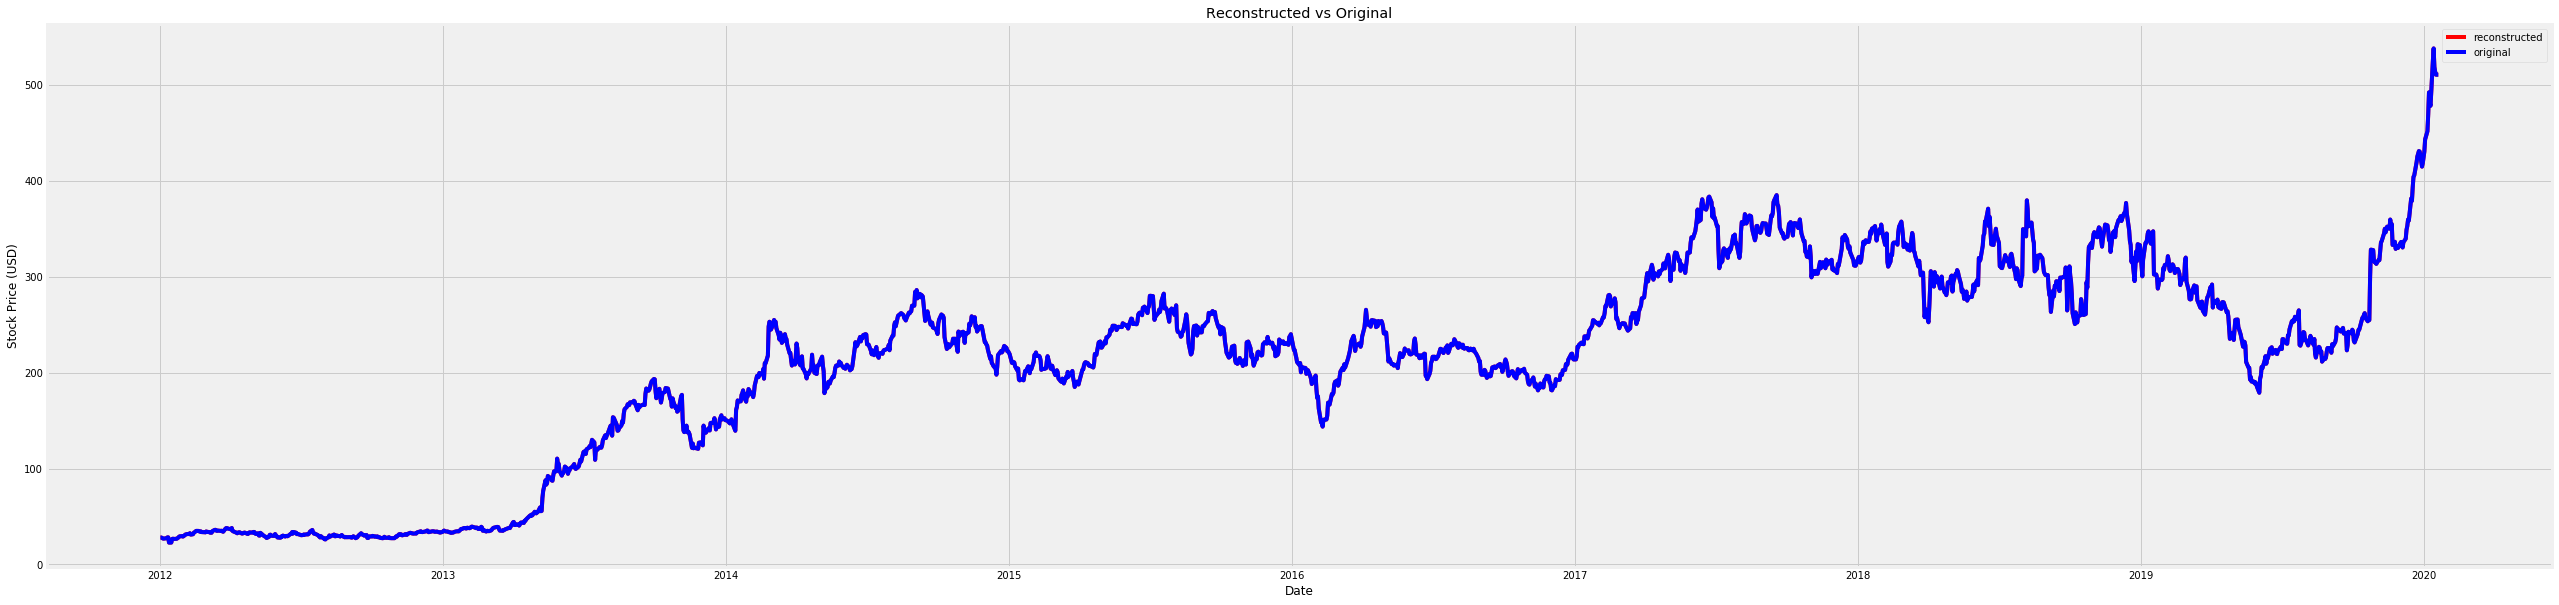

In [32]:
plt.plot(tesla.index, tesla_reconstruct['Close'], 'r-',  label='reconstructed')
plt.plot(tesla.index, tesla['Close'], 'b-', label = 'original')
plt.xlabel('Date'); plt.ylabel('Stock Price (USD)')
plt.title('Reconstructed vs Original')
plt.legend();

In [33]:
tesla.equals(tesla_reconstruct)

True

In [165]:
class TimeSeriesData():
    def __init__(self, df):
        self.data = df 
        self.stationary = self.stationarize(df)
        self.reconstructed = self.reconstruct(self.stationary, self.data)
        
    def reconstruct(self, st, org):
        x = st.copy()
        x.iloc[0,:] = org.iloc[0,:]
        return x.cumsum()
    
    def stationarize(self, data):
        return data.diff(1).fillna(0)

In [166]:
x_train = TimeSeriesData(tesla[:int((len(tesla)*0.9))])
x_valid = TimeSeriesData(tesla[int((len(tesla)*0.9)):])
x_train.data.shape[0] + x_valid.data.shape[0] == tesla.shape[0]

True

In [252]:
x_valid.data.shape

(208, 6)

In [253]:
x_train.data.shape

(1870, 6)

Now that we know differencing once will make our data into stationary, we will later might use the differenced data. 

# Autocorrelation and Partial Autocorrelation

Autocorrelation is a correlation of time-series data with its own lag. It the correlation is high, it's mean that previous data will be helpful in forecasting the future. While partial autocorrelation is likely the same but it measure pure correlation between series and its lag. 

We can use acf and pacf plot from `statsmodel` to help us measure the correlation between series on several lag


In [433]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

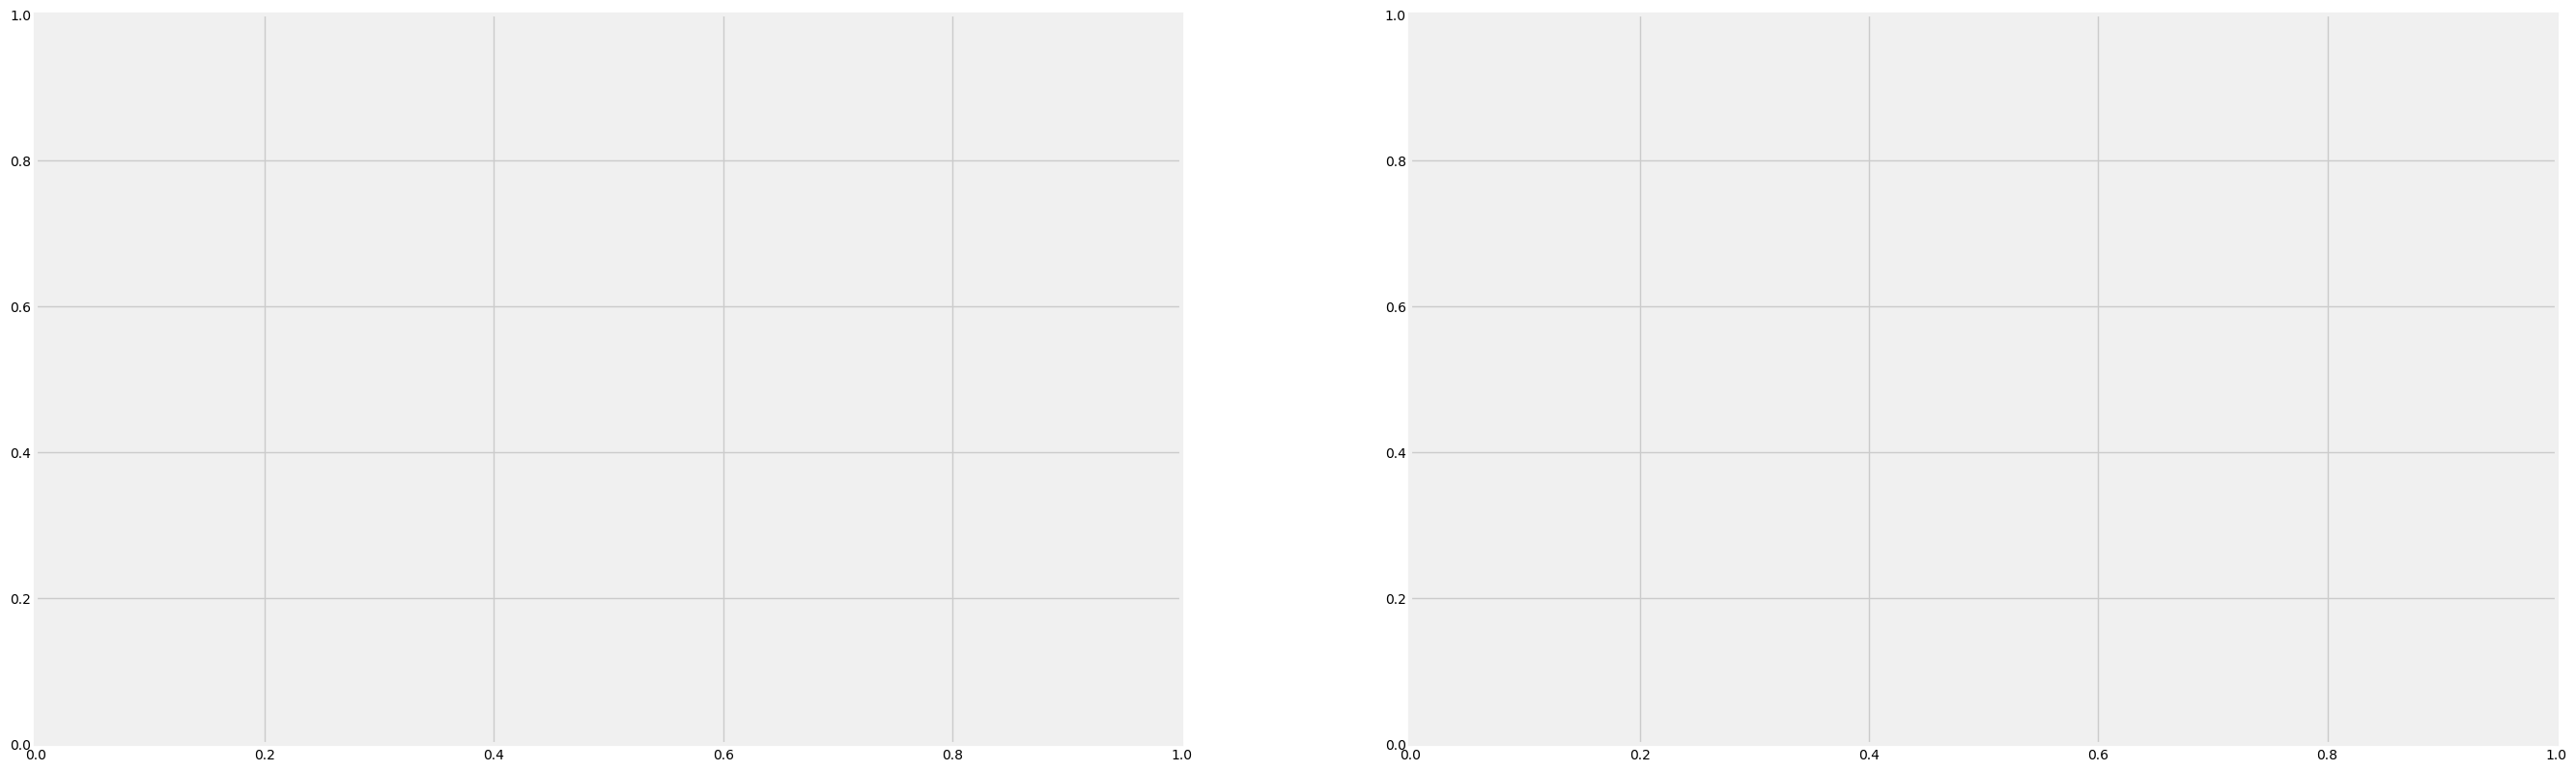

In [434]:
fig, axes = plt.subplots(1,2,figsize=(30,10), dpi= 100)

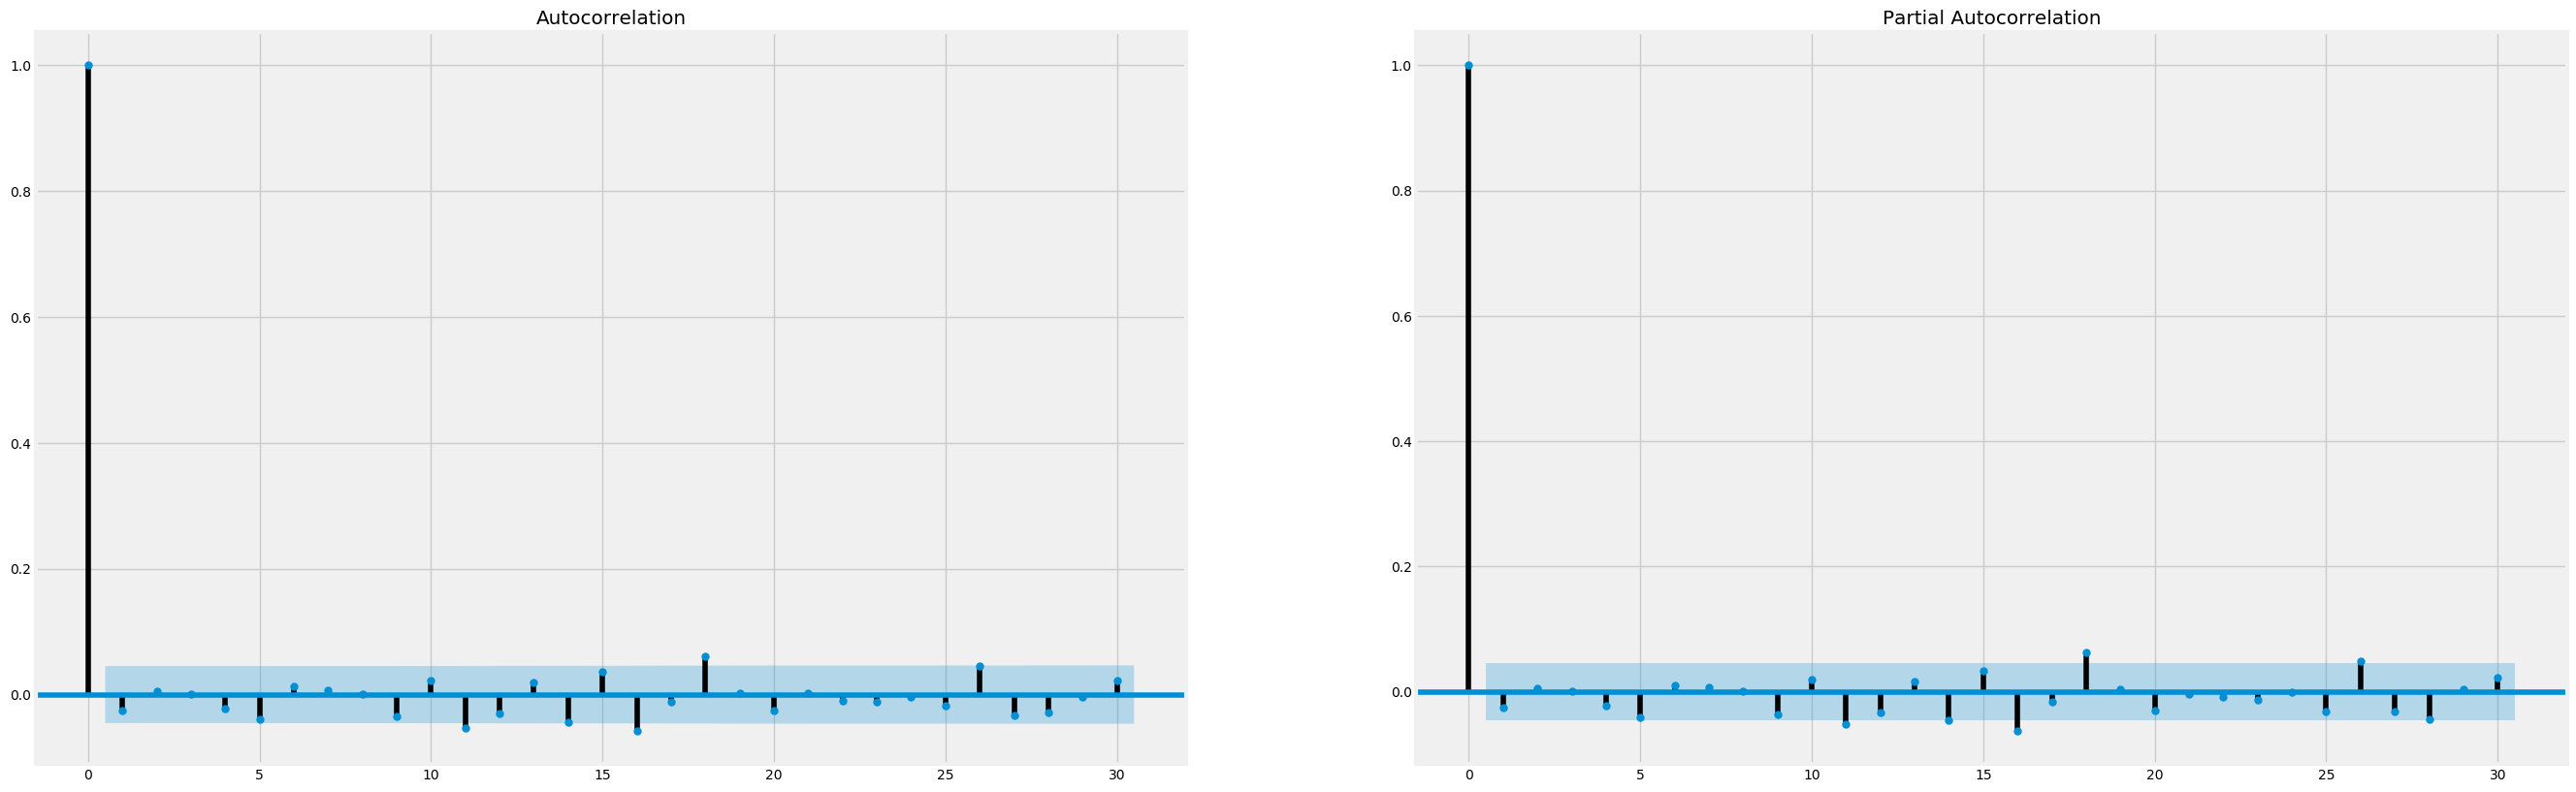

In [435]:
plot_acf(x_train.stationary['Close'].values.tolist(), lags=30, ax=axes[0])
plot_pacf(x_train.stationary['Close'].values.tolist(), lags=30, ax=axes[1])

If we see the autocorrelation and partial auto correlation values, the values forms cutoff pattern on both ACF and PACF result. This indicating that we can model the data using Auto Regressive and its Moving Average. Pleas see the lag that almost cross or crossed the blue threshold on each plot. In PACF, the first lag that almost cross the blue threshold is 5, so we will be using P=5. 

On the other side, the first lag on ACF plot that crossed / almost crossed the blue threshold is also 5, so we will be using q=5. 

# Time Series Forecasting (ARIMA)

In [408]:
from statsmodels.tsa.arima_model import ARIMA #, ARIMAResults, ARIMAResultsWrapper

## Modelling

ARIMA models will require (p, d, q) arguments, 
where
p: 
d:
q:



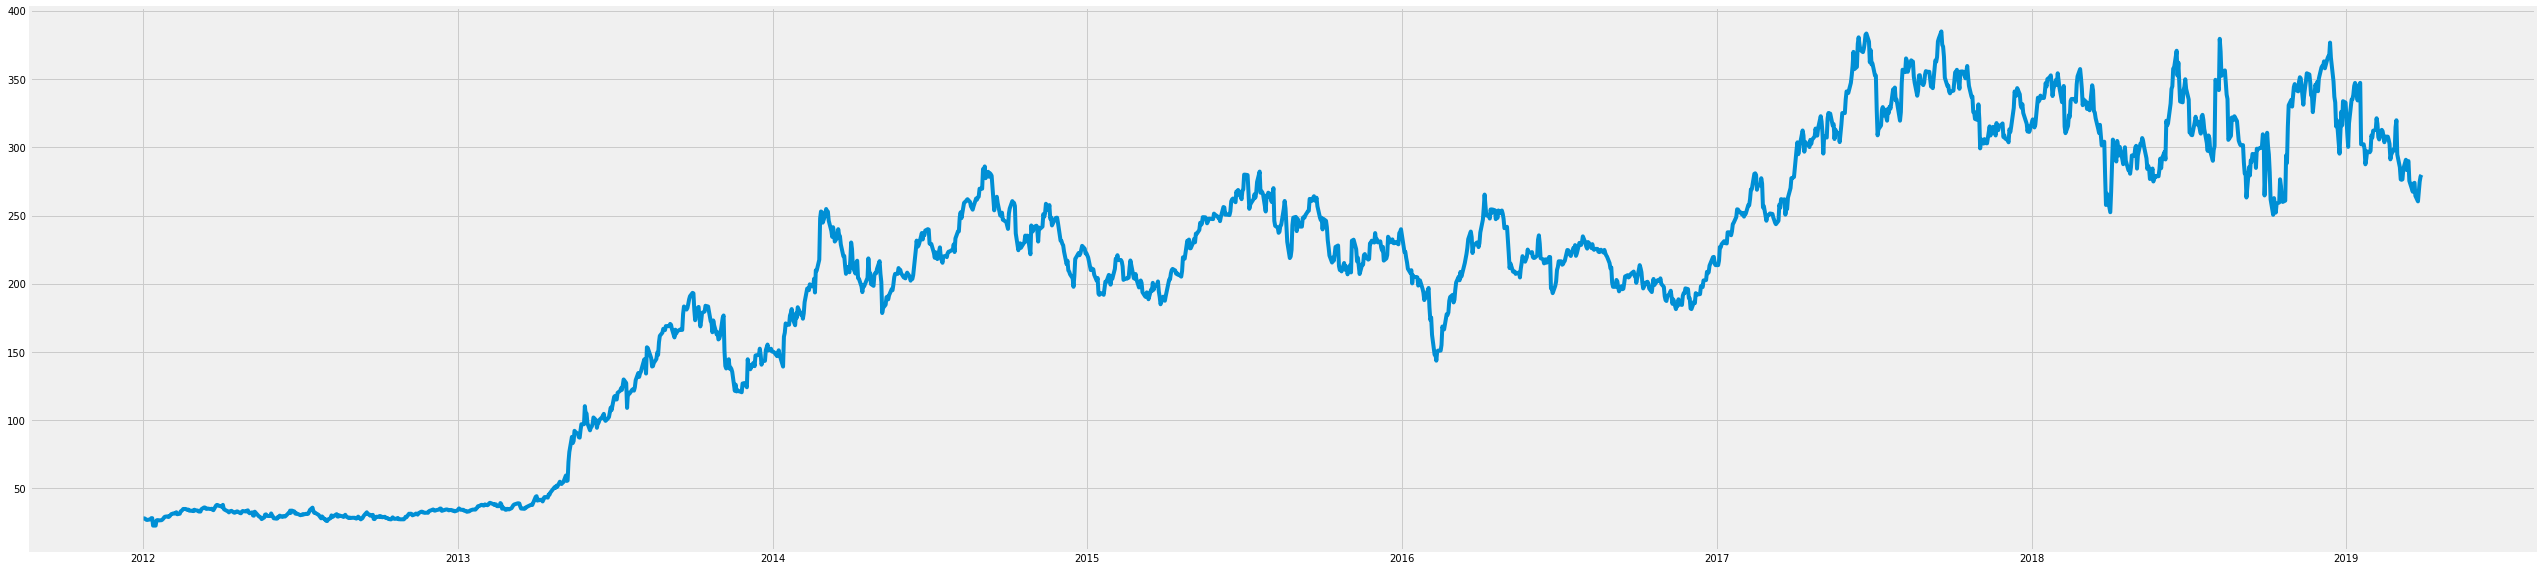

In [173]:
plt.plot(x_train.data['Close'])

In [411]:
model_arima = ARIMA(x_train.data['Close'].values, order=(5,1,5))
# or model_arima = ARIMA(x_train.stationary['Close'].values, order=(5,0,5))

In [349]:
result_arima = model_arima.fit(disp=-1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [361]:
print(result_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1869
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -6165.740
Method:                       css-mle   S.D. of innovations              6.546
Date:                Thu, 30 Jan 2020   AIC                          12355.479
Time:                        15:09:38   BIC                          12421.877
Sample:                             1   HQIC                         12379.943
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1358      0.152      0.894      0.371      -0.162       0.433
ar.L1.D.y     -0.1594      0.019     -8.380      0.000      -0.197      -0.122
ar.L2.D.y     -0.9588      0.019    -51.330      0.0

### Inspect the residuals

Now that we have our models, we don't want the residuals to be have autocorrelation. Thus, let's try to see the ACF-PACF values for each residual lag

In [418]:
residuals = pd.DataFrame(result_arima.resid)

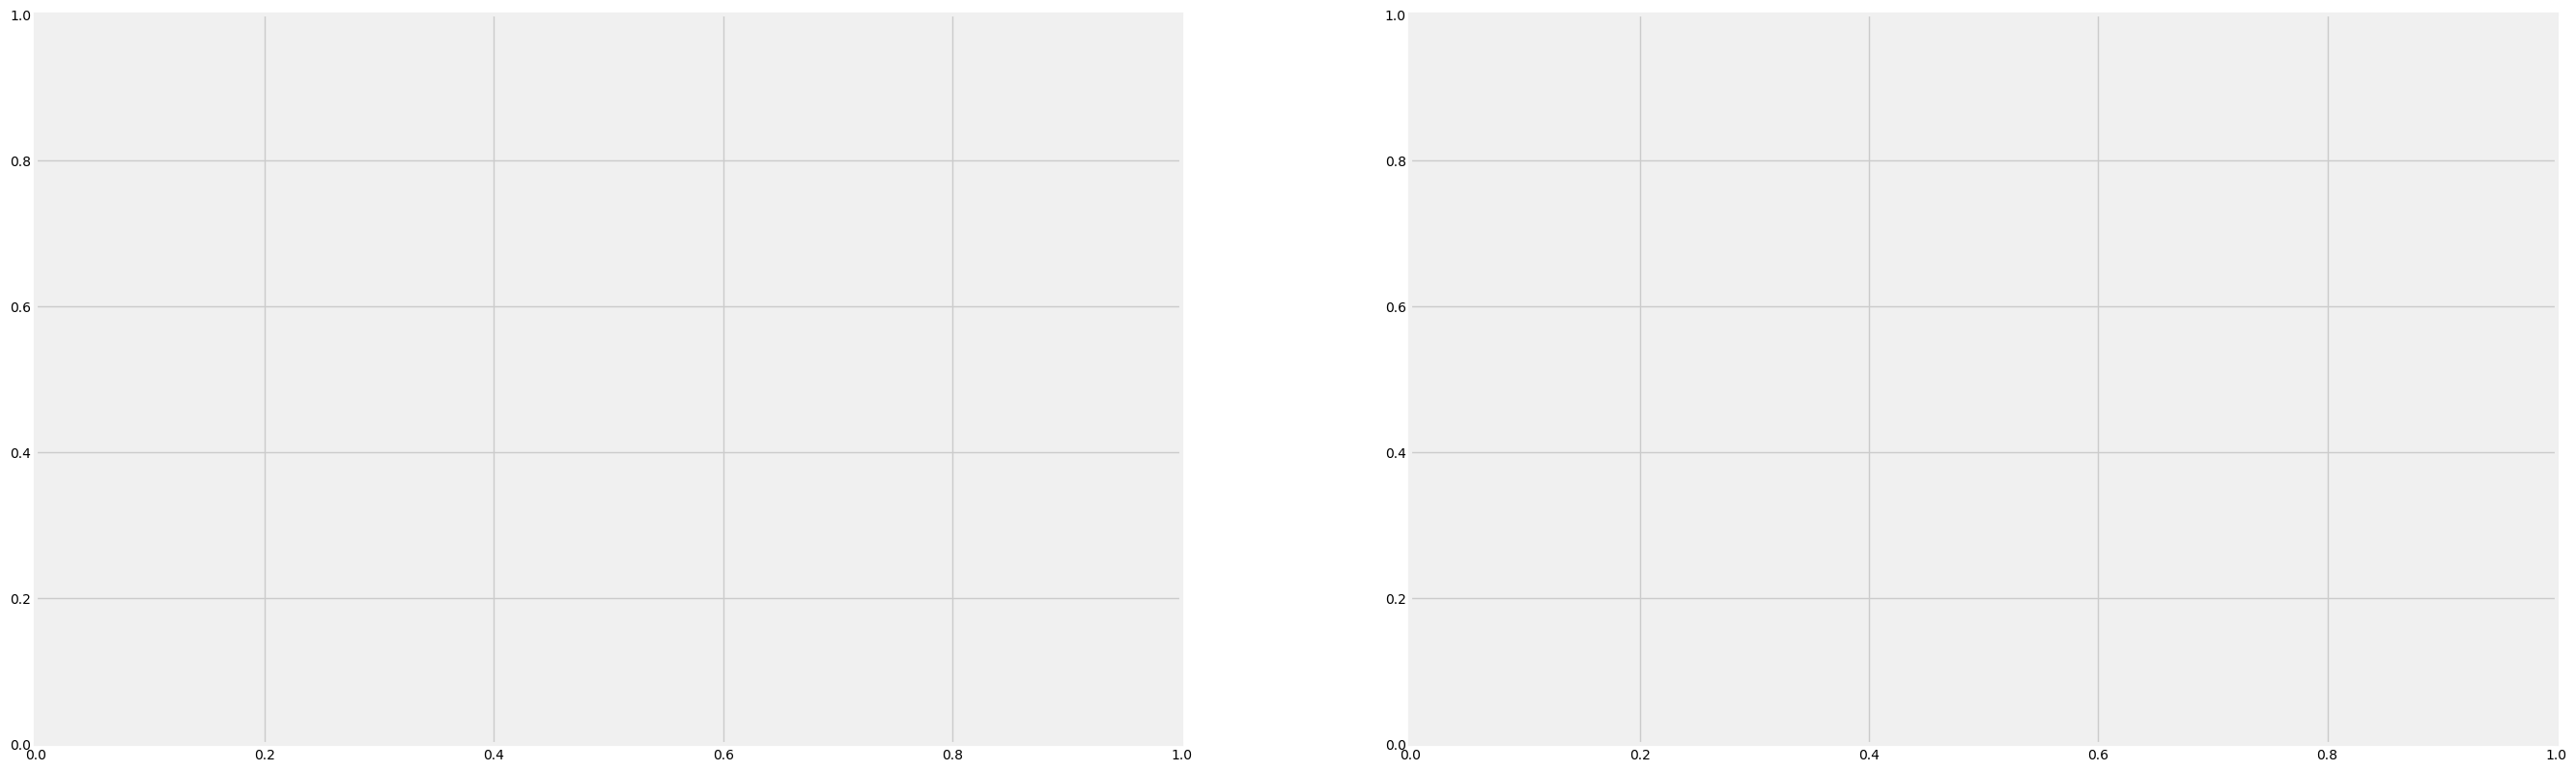

In [419]:
fig, axes = plt.subplots(1,2,figsize=(30,10), dpi= 100)

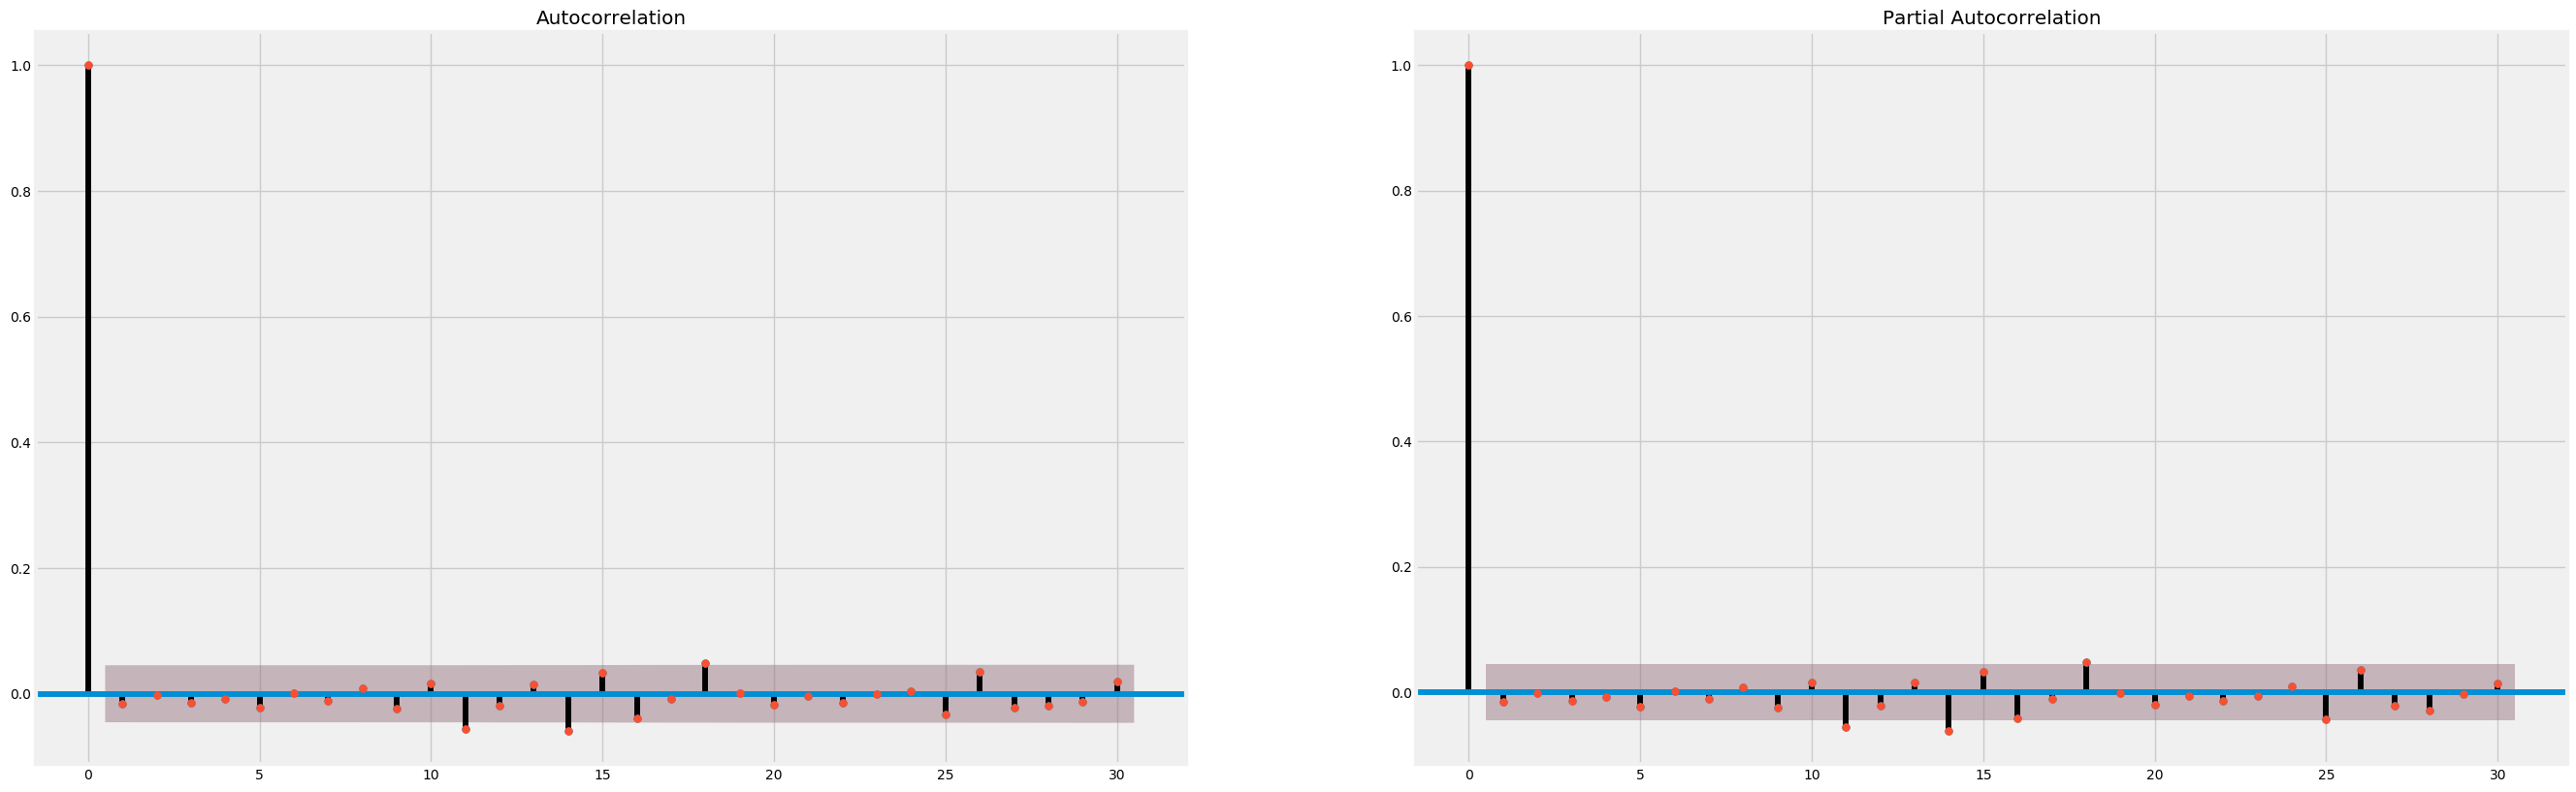

In [422]:
plot_acf(residuals, lags=30, ax=axes[0])
plot_pacf(residuals, lags=30, ax=axes[1])

We also want to make sure the residuals are random, concentrated in zero,

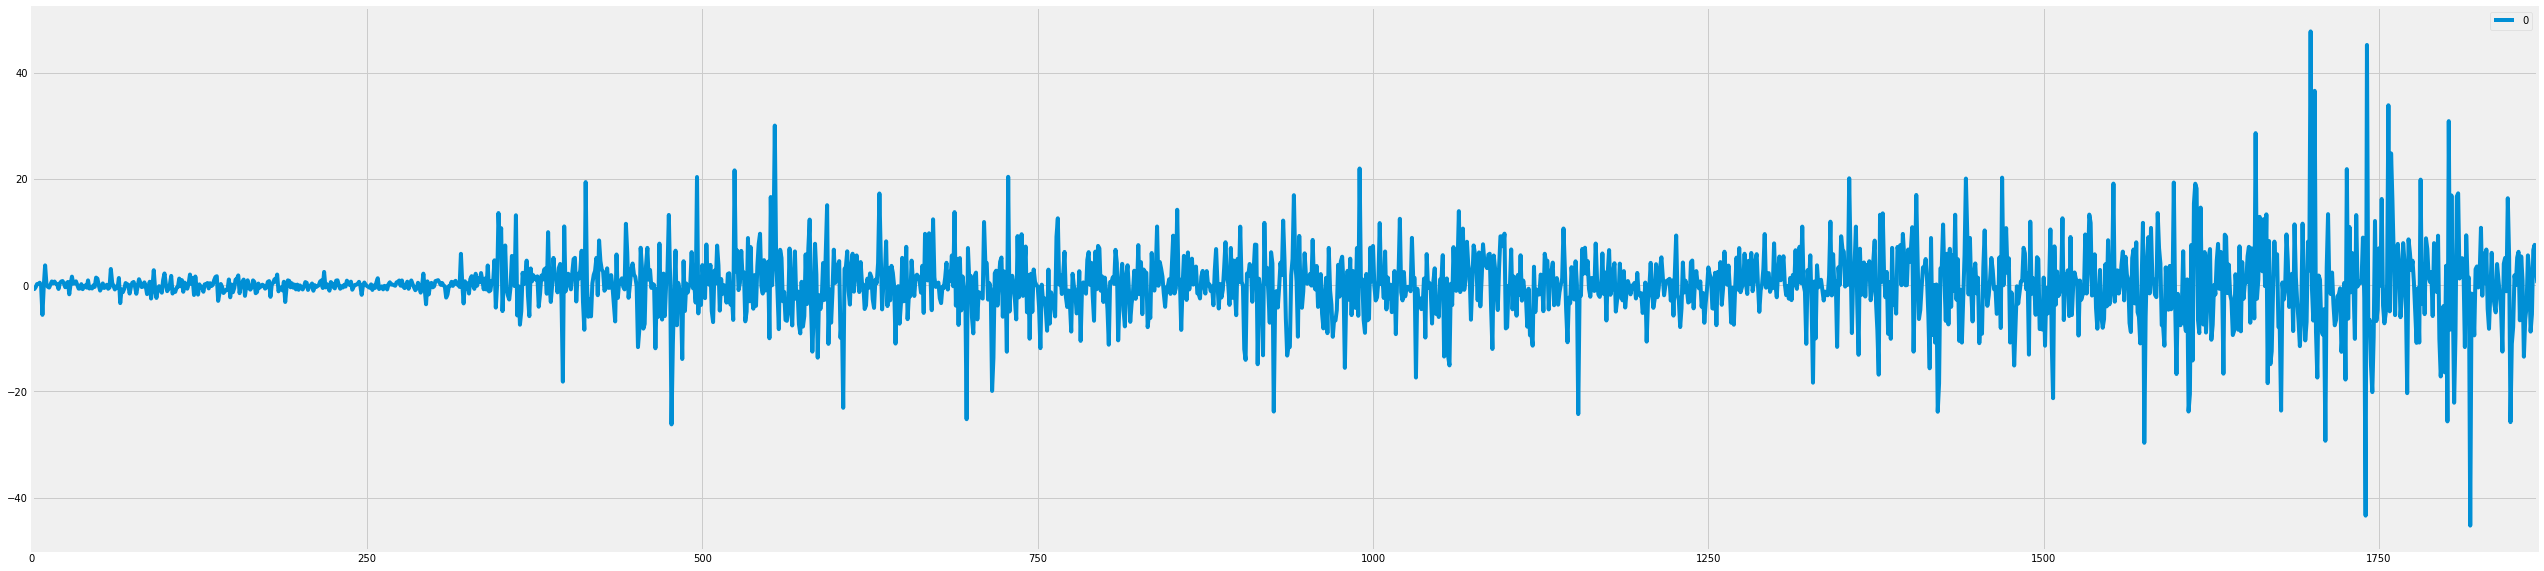

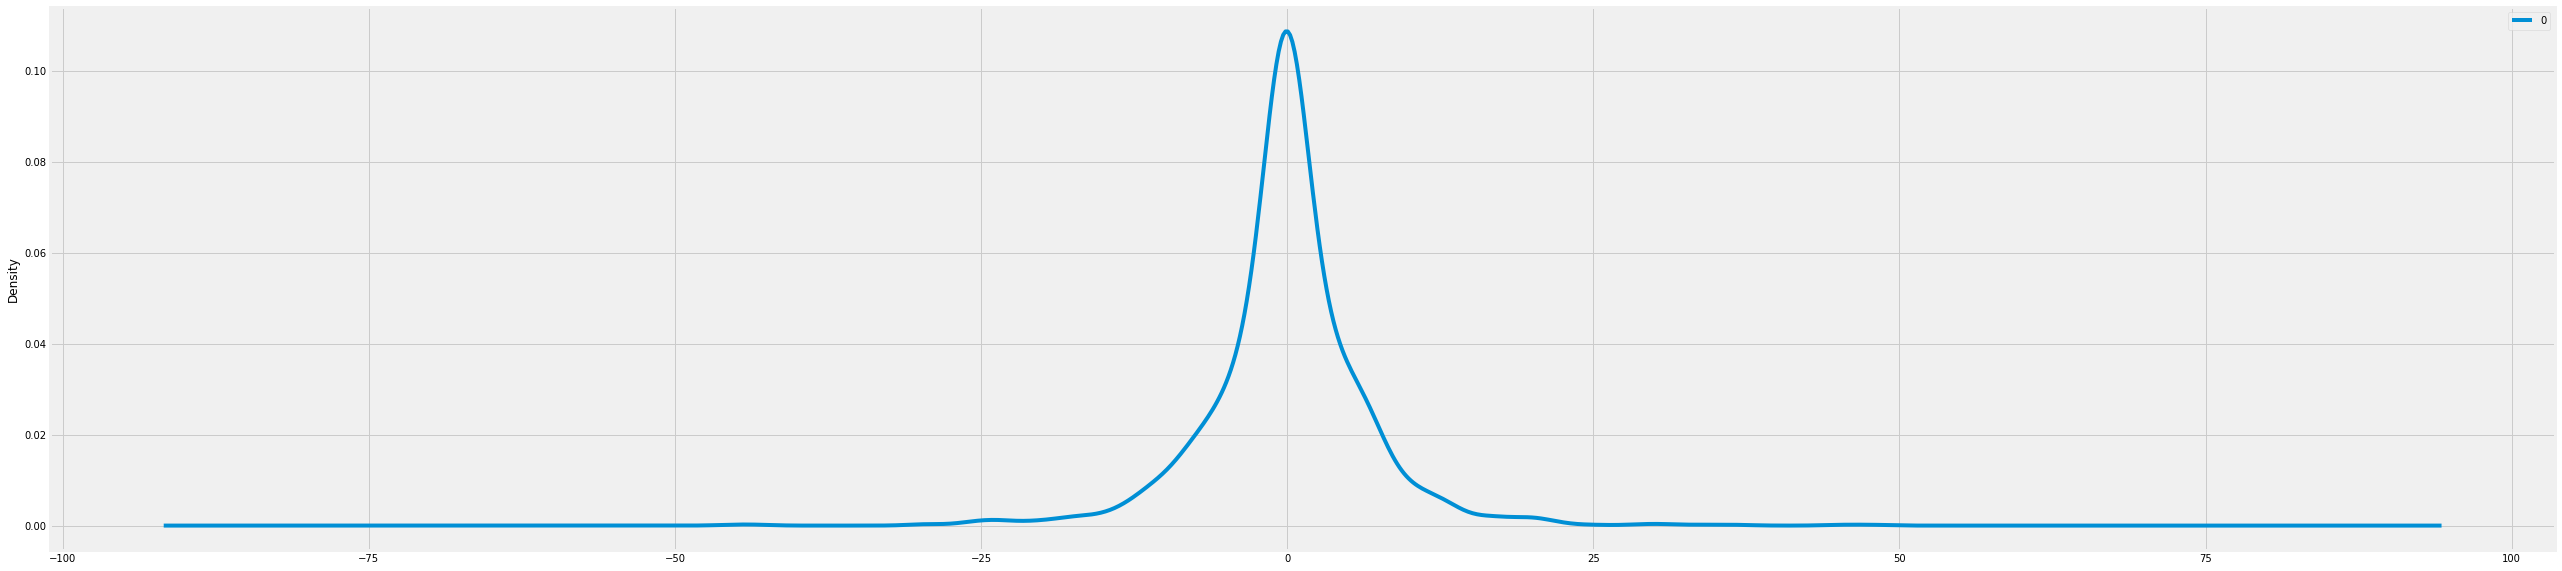

In [423]:
residuals.plot()
residuals.plot(kind='kde')

## Model Evaluation

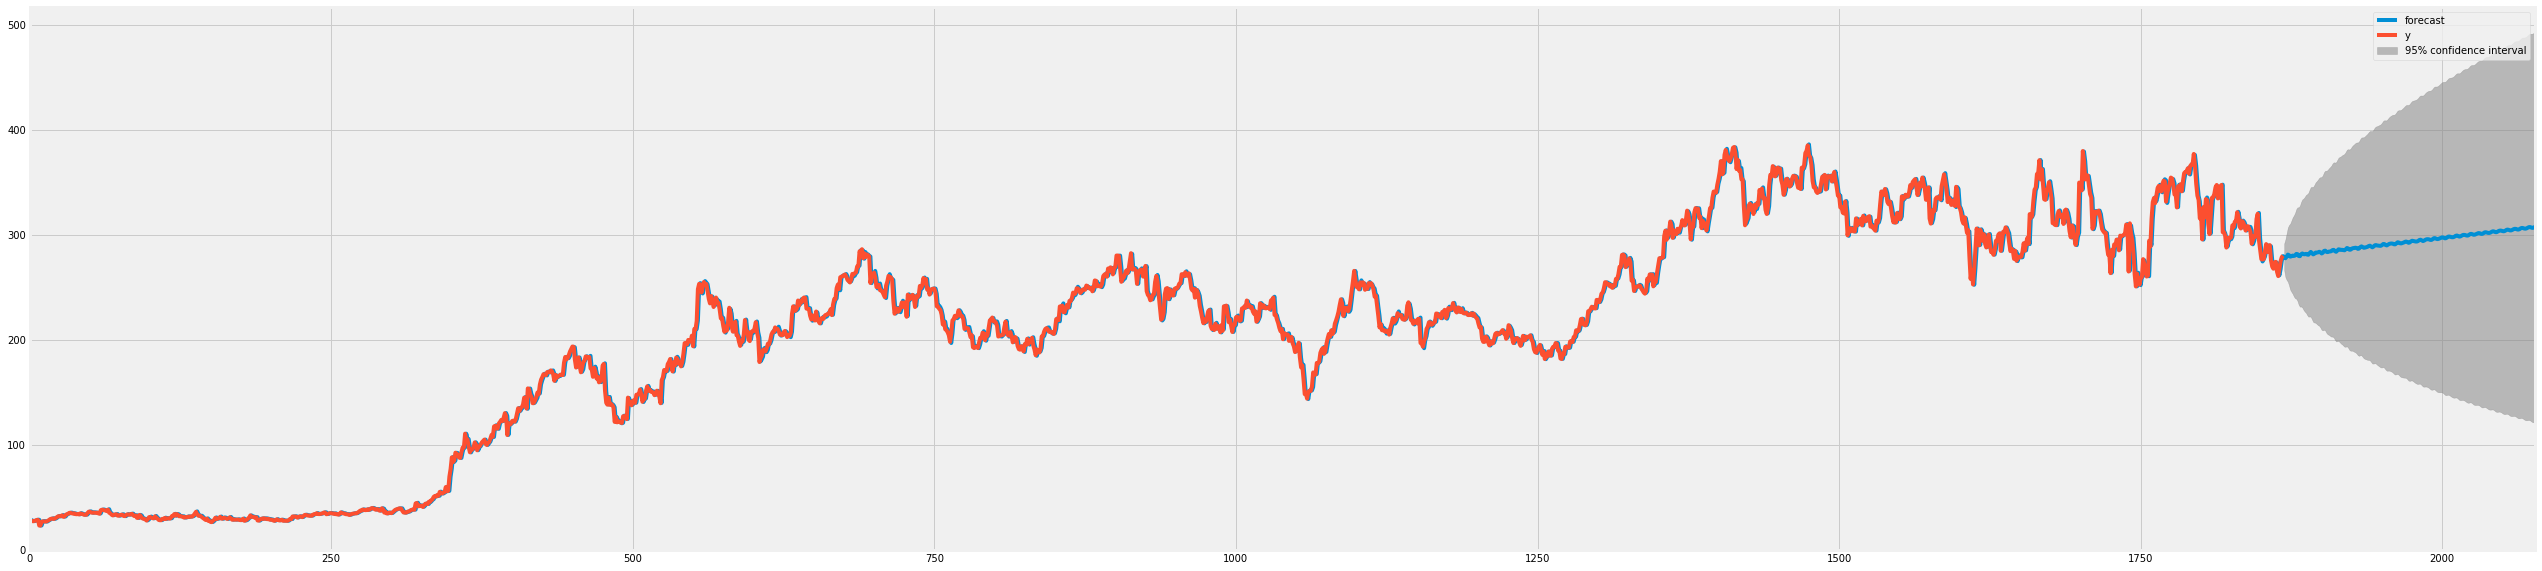

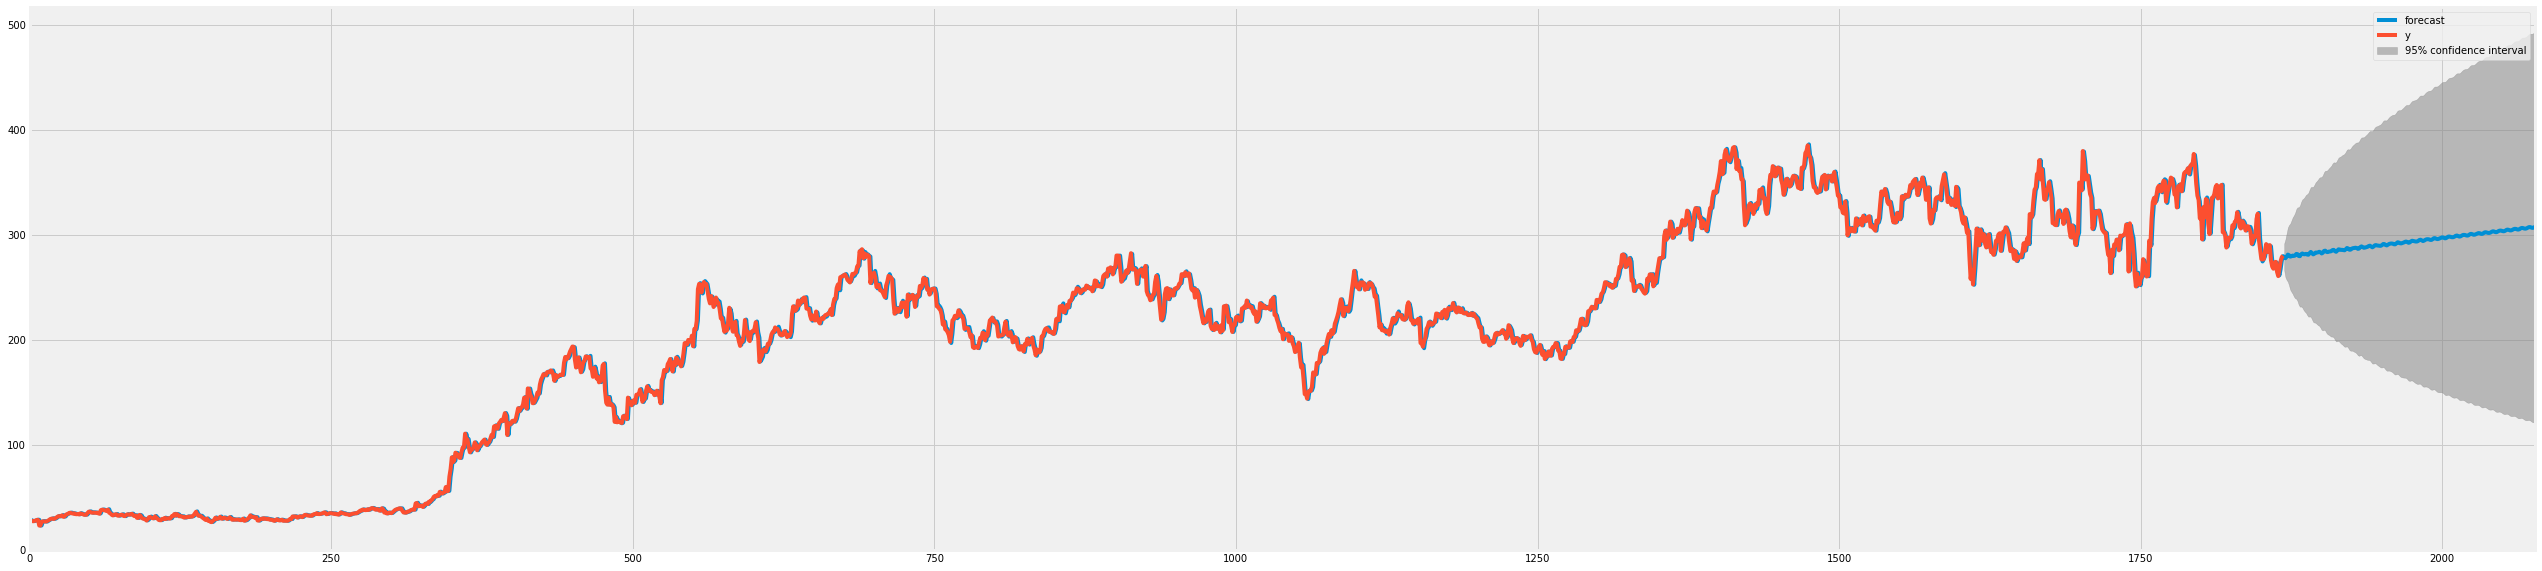

In [351]:
result_arima.plot_predict(1,1870+208)

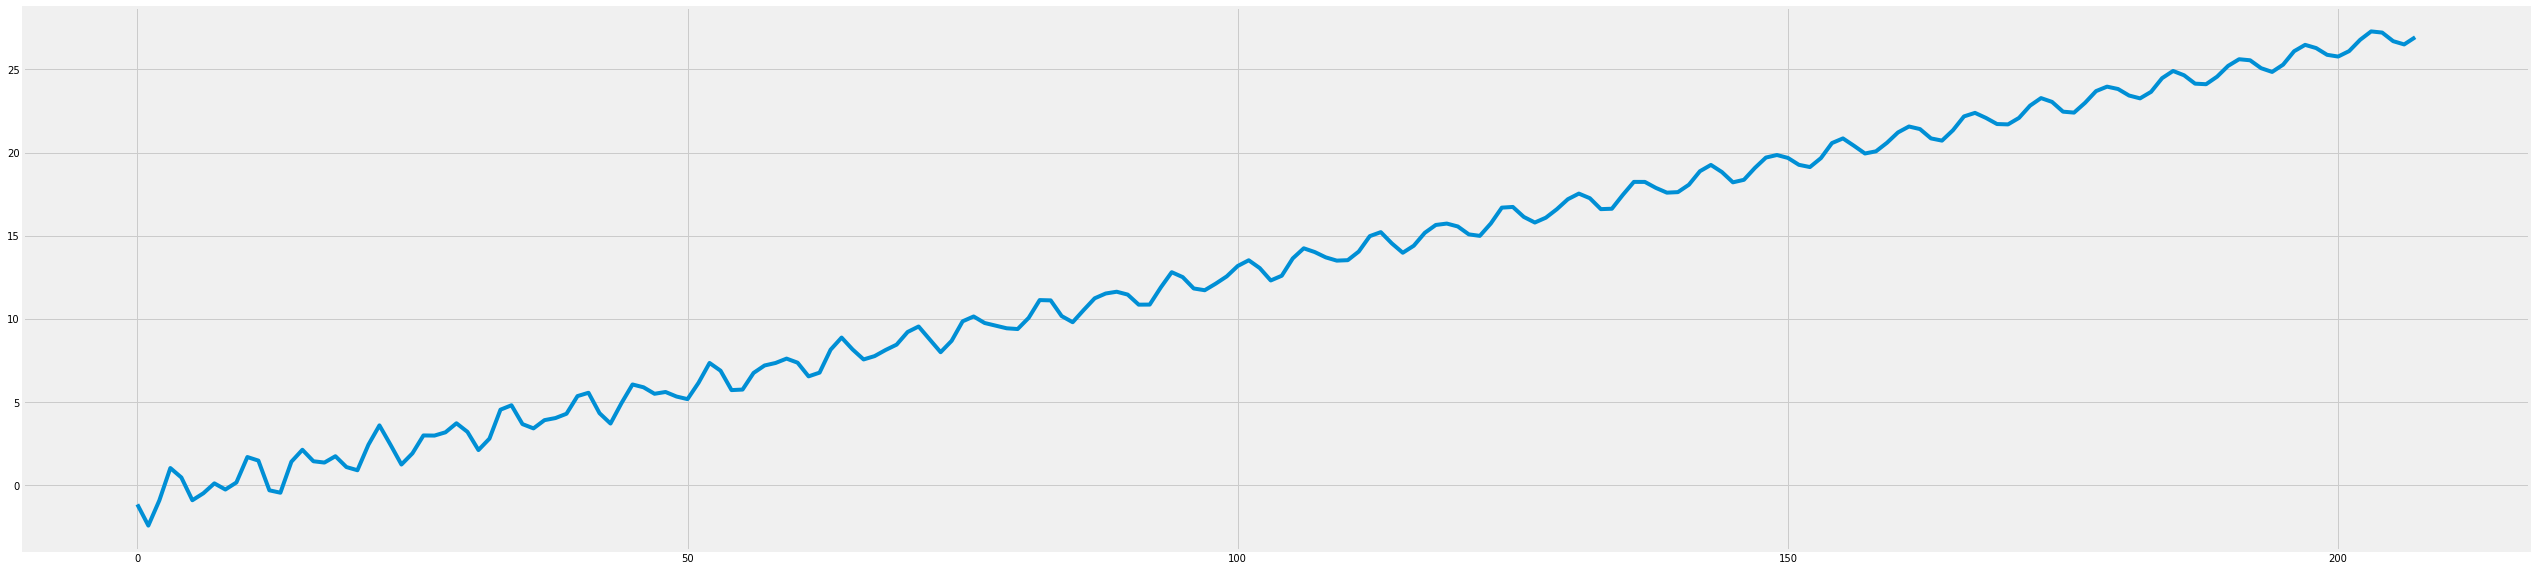

In [430]:
pred = result_arima.predict(len(tesla)-208,len(tesla)-1)
plt.plot(pred.cumsum())

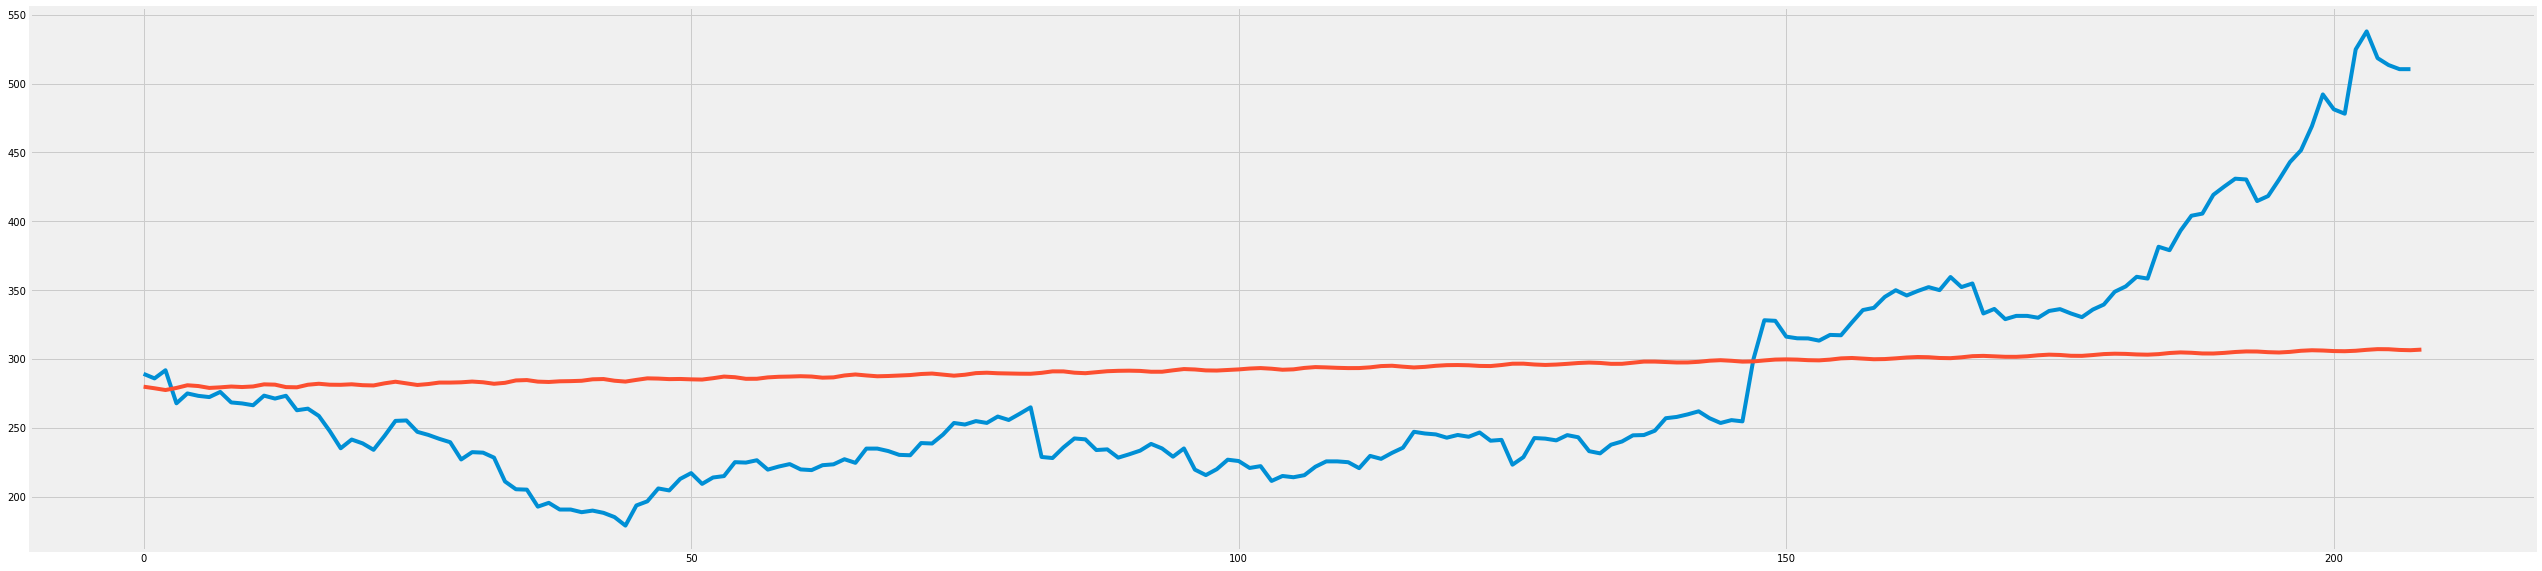

In [431]:
plt.plot(x_valid.data['Close'].values)
plt.plot(np.append(x_train.data.iloc[-1,:]['Close'], pred).cumsum())

In [432]:
print(f"MSE: {np.mean((pred - x_valid.stationary['Close'])**2)}")

MSE: 80.17112063456592
